# MLP Training for Flow Field Reconstruction

This notebook provides training for MLP-based flow field reconstruction models using the same methodology as FLRNet.

**Architecture:**
- Direct sensor-to-field reconstruction using Deep MLP
- No VAE encoder/decoder - simplified architecture
- Same data preprocessing and training pipeline as FLRNet

**Training Strategy:**
- Unified configuration management
- Automatic dataset creation and loading
- Advanced callbacks and checkpointing
- Validation and testing workflows

## Imports and Configuration

In [7]:
# Standard imports
import os
import sys
import numpy as np
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
import json

# Local imports (same as FLRNet)
import config_manager
from data.flow_field_dataset import FlowFieldDatasetCreator
from mlp_models import MLPReconstructionModel, MLPTrainer

# Configure TensorFlow (same as FLRNet)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

# Enable memory growth for GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU memory growth enabled for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"⚠️ Error setting GPU memory growth: {e}")
else:
    print("🔍 No GPUs found, using CPU")

print(f"TensorFlow version: {tf.__version__}")
print(f"Available devices: {[device.name for device in tf.config.list_logical_devices()]}")

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Environment setup complete!")

✅ GPU memory growth enabled for 1 GPU(s)
TensorFlow version: 2.8.0
Available devices: ['/device:CPU:0', '/device:GPU:0']
✅ Environment setup complete!


## Configuration Loading (Same as FLRNet)

In [8]:
# Load configuration (exact same pattern as FLRNet)
config_name = "random_32_standard"  # Available: edge_32_standard, circular_32_standard, random_32_standard, etc.

# Initialize config manager
config_manager_instance = config_manager.ConfigManager("config")

# Load and display configuration
try:
    config = config_manager_instance.load_config(config_name)
    print(f"✅ Successfully loaded configuration: {config_name}")
    
    print("\n📋 Configuration Summary:")
    print("=" * 60)
    print(f"Model Type: MLP (Direct Sensor → Field)")
    print(f"Sensor Layout: {config['sensors']['layout']}")
    print(f"Number of Sensors: {config['sensors']['n_sensors']}")
    print(f"Input Shape: {config['model']['input_shape']}")
    print(f"Batch Size: {config['training']['batch_size']}")
    print(f"Dataset Path: {config.get('dataset_path', 'Will be created')}")
    print(f"Checkpoint Dir: {config['checkpoint_dir']}")
    print(f"Logs Dir: {config['logs_dir']}")
    print(f"Model Name: {config['model_name']}")
    
    # Extract key parameters for MLP training
    n_sensors = config['sensors']['n_sensors']
    sensor_layout = config['sensors']['layout']
    input_shape = tuple(config['model']['input_shape'])
    batch_size = config['training']['batch_size']
    
    print("\n✅ Configuration loaded successfully!")
    
except Exception as e:
    print(f"❌ Error loading configuration: {e}")
    print("Available configurations:")
    try:
        available_configs = config_manager_instance.list_configs()
        for cfg in available_configs:
            print(f"  - {cfg}")
    except:
        print("  Could not list available configurations")
    raise

✅ Successfully loaded configuration: random_32_standard

📋 Configuration Summary:
Model Type: MLP (Direct Sensor → Field)
Sensor Layout: random
Number of Sensors: 32
Input Shape: [128, 256, 1]
Batch Size: 8
Dataset Path: data/datasets\dataset_random_32.npz
Checkpoint Dir: ./checkpoints\fourierTrue_percepTrue_random_32
Logs Dir: ./logs\fourierTrue_percepTrue_random_32
Model Name: fourierTrue_percepTrue_random_32

✅ Configuration loaded successfully!


## Dataset Creation and Loading (Same as FLRNet)

In [9]:
# Load and prepare dataset created from data_creation_and_viz.ipynb (same as FLRNet)
print(f"📁 Loading dataset from: {config['dataset_path']}")

# Parse the dataset filename to get layout and n_sensors
dataset_filename = Path(config['dataset_path']).name
# Expected format: dataset_edge_8.npz
parts = dataset_filename.split('_')
layout_type = parts[1]  # 'edge'
n_sensors = int(parts[2].split('.')[0])  # 8

print(f"📊 Dataset parameters:")
print(f"   Layout type: {layout_type}")
print(f"   Number of sensors: {n_sensors}")

# Load the dataset directly from the NPZ file
print(f"📁 Loading dataset file: {config['dataset_path']}")
data = np.load(config['dataset_path'])

# Check what keys are available in the dataset
print(f"📋 Available keys in dataset: {list(data.keys())}")

# Create dataset dictionary
dataset = {key: data[key] for key in data.keys()}

# Print dataset information
print(f"📊 Dataset loaded successfully:")
for key, value in dataset.items():
    if isinstance(value, np.ndarray):
        print(f"   {key}: {value.shape} ({value.dtype})")
    else:
        print(f"   {key}: {value}")

# Extract sensor positions
sensor_positions = dataset['sensor_positions']
print(f"📍 Sensor positions shape: {sensor_positions.shape}")

# Create dataset creator instance for TensorFlow dataset creation
creator = FlowFieldDatasetCreator(
    output_path="./data/",
    domain_shape=input_shape,  # (height, width)
    use_synthetic_data=False  # Don't create synthetic data, just use for TF dataset creation
)

# Create TensorFlow datasets using the creator's method
train_dataset, test_dataset = creator.create_tensorflow_dataset(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    test_split=config['training']['test_split']  # Fix: Access test_split from training section
)

print(f"\n📊 TensorFlow datasets created:")
print(f"   Train dataset: {train_dataset}")
print(f"   Test dataset: {test_dataset}")

# Function to add coordinate grids to field data for coordinate-aware training
def add_coordinate_grid(batch):
    """Add coordinate grid to field data for coordinate-aware training"""
    field_data = batch['field_data']
    
    # Get dimensions
    batch_size = tf.shape(field_data)[0]
    height = tf.shape(field_data)[1]
    width = tf.shape(field_data)[2]
    
    # Create normalized coordinate grids [0, 1] - match field dimensions
    x_coords = tf.linspace(0.0, 1.0, width)   # Width corresponds to x
    y_coords = tf.linspace(0.0, 1.0, height)  # Height corresponds to y
    
    # Create meshgrid to match image indexing: [height, width, 2]
    y_grid, x_grid = tf.meshgrid(y_coords, x_coords, indexing='ij')
    
    # Stack to create coordinate grid (height, width, 2)
    coord_grid = tf.stack([x_grid, y_grid], axis=-1)
    
    # Expand to batch size (batch_size, height, width, 2)
    coord_batch = tf.tile(tf.expand_dims(coord_grid, 0), [batch_size, 1, 1, 1])
    
    # Update batch to include coordinates
    return {
        'field_data': field_data,
        'sensor_data': batch['sensor_data'],
        'coordinates': coord_batch
    }

# Add coordinate grids to datasets
coord_train_dataset = train_dataset.map(add_coordinate_grid)
coord_test_dataset = test_dataset.map(add_coordinate_grid)

print(f"\n📊 Coordinate-aware datasets created:")
print(f"   Train dataset with coordinates: {coord_train_dataset}")
print(f"   Test dataset with coordinates: {coord_test_dataset}")

# Create MLP datasets for sensor-to-field reconstruction (same pattern as FLRNet)
print("\n🔄 Creating MLP datasets...")
# MLP: input = sensor, output = field (direct sensor-to-field mapping)
mlp_train_dataset = coord_train_dataset.map(
    lambda batch: (batch['sensor_data'], batch['field_data'])
)
mlp_test_dataset = coord_test_dataset.map(
    lambda batch: (batch['sensor_data'], batch['field_data'])
)
print("✅ MLP datasets created")

print(f"\n📊 MLP datasets:")
print(f"   MLP train dataset: {mlp_train_dataset}")
print(f"   MLP test dataset: {mlp_test_dataset}")

# Get a sample to verify data shapes
print(f"\n📊 Data shape verification:")
for batch in coord_train_dataset.take(1):
    print(f"   Sensor data shape: {batch['sensor_data'].shape}")
    print(f"   Field data shape: {batch['field_data'].shape}")
    print(f"   Coordinates shape: {batch['coordinates'].shape}")
    break

# Verify MLP dataset structure
print(f"\n📊 MLP dataset structure verification:")
for mlp_batch in mlp_train_dataset.take(1):
    inputs, targets = mlp_batch
    print(f"   MLP sensor input shape: {inputs.shape}")
    print(f"   MLP field target shape: {targets.shape}")
    break

📁 Loading dataset from: data/datasets\dataset_random_32.npz
📊 Dataset parameters:
   Layout type: random
   Number of sensors: 32
📁 Loading dataset file: data/datasets\dataset_random_32.npz
📋 Available keys in dataset: ['sensor_data', 'field_data', 'sensor_positions', 'reynolds_numbers', 'layout_type', 'n_sensors']
📊 Dataset loaded successfully:
   sensor_data: (28, 32, 39) (float64)
   field_data: (28, 128, 256, 39) (float64)
   sensor_positions: (32, 2) (float64)
   reynolds_numbers: (28,) (int32)
   layout_type: () (<U6)
   n_sensors: () (int32)
📍 Sensor positions shape: (32, 2)
📊 Dataset Creator initialized:
   Domain shape: (128, 256, 1)
   Caching: ✅ ENABLED
   Cache directory: data\cache
Dataset reshaped:
  Original sensor data: (28, 32, 39)
  Reshaped sensor data: (1092, 32)
  Original field data: (28, 128, 256, 39)
  Reshaped field data: (1092, 128, 256, 1)
  Total samples: 1092
TensorFlow datasets created:
  Train samples: 873
  Test samples: 219

📊 TensorFlow datasets create

## Data Preprocessing and TensorFlow Dataset Creation

In [10]:
# Data preprocessing using MLP datasets (same approach as FLRNet)
print("🔧 Using MLP datasets for training...")

# Split the training dataset for validation (same split as FLRNet)
print("\n📦 Creating training and validation splits...")

# Get total number of batches in training dataset
total_train_batches = tf.data.experimental.cardinality(mlp_train_dataset).numpy()
val_split = config['training'].get('test_split', 0.2)  # This gets 0.2
train_batches = int((1 - val_split) * total_train_batches)  # This calculates 80% for training


print(f"📊 Dataset split information:")
print(f"   Total training batches: {total_train_batches}")
print(f"   Training batches: {train_batches}")
print(f"   Validation batches: {total_train_batches - train_batches}")
print(f"   Test batches: {tf.data.experimental.cardinality(mlp_test_dataset).numpy()}")

# Split training dataset
train_dataset = mlp_train_dataset.take(train_batches)
val_dataset = mlp_train_dataset.skip(train_batches)

# Use test dataset as is
test_dataset = mlp_test_dataset

print(f"✅ Datasets prepared:")
print(f"  Training batches: {tf.data.experimental.cardinality(train_dataset)}")
print(f"  Validation batches: {tf.data.experimental.cardinality(val_dataset)}")
print(f"  Test batches: {tf.data.experimental.cardinality(test_dataset)}")

# Inspect batch shapes (same verification as FLRNet)
for sensor_batch, field_batch in train_dataset.take(1):
    print(f"\n🔍 Batch shapes:")
    print(f"  Sensor batch: {sensor_batch.shape}")
    print(f"  Field batch: {field_batch.shape}")
    print(f"  Batch data ranges: sensor [{tf.reduce_min(sensor_batch):.3f}, {tf.reduce_max(sensor_batch):.3f}], field [{tf.reduce_min(field_batch):.3f}, {tf.reduce_max(field_batch):.3f}]")

🔧 Using MLP datasets for training...

📦 Creating training and validation splits...
📊 Dataset split information:
   Total training batches: 110
   Training batches: 88
   Validation batches: 22
   Test batches: 28
✅ Datasets prepared:
  Training batches: 88
  Validation batches: 22
  Test batches: 28

🔍 Batch shapes:
  Sensor batch: (8, 32)
  Field batch: (8, 128, 256, 1)
  Batch data ranges: sensor [0.024, 2.762], field [0.000, 2.930]


## Model Definition and Training Setup

In [11]:
# Model configuration (optimized for efficiency)
print("🏗️ Setting up MLP model...")

# Use sensor count from dataset parsing (same as FLRNet)
n_sensors_from_dataset = n_sensors  # From dataset filename parsing
print(f"📊 Using {n_sensors_from_dataset} sensors from dataset")

# MLP architecture configuration
mlp_config = {
    'n_sensors': n_sensors_from_dataset,
    'input_shape': tuple(config['model']['input_shape']),
    'hidden_layers': [64, 64, 128, 128, 256],  # Efficient architecture
    'activation': 'relu',
    'dropout_rate': 0.2,
    'use_batch_norm': True,
    'gradient_clip_norm': config['training'].get('gradient_clip_norm', 1.0)
}

# Training configuration (same parameters as FLRNet)
training_config = {
    'epochs': 150,  # Adjust as needed
    'learning_rate': config['training'].get('flr_learning_rate', 0.0001),
    'patience': config['training'].get('patience', 25),
    'reduce_lr_patience': config['training'].get('reduce_lr_patience', 8),
}

print(f"📋 Model Configuration:")
for key, value in mlp_config.items():
    print(f"  {key}: {value}")

print(f"\n🎯 Training Configuration:")
for key, value in training_config.items():
    print(f"  {key}: {value}")

# Initialize trainer (same pattern as FLRNet)
model_name = f"mlp_{config['model_name']}"

trainer = MLPTrainer(
    input_shape=tuple(config['model']['input_shape']),
    checkpoint_dir=config['checkpoint_dir'],
    logs_dir=config['logs_dir'],
    model_name=model_name,
    save_best_model=config['output']['save_best_model'],
    save_last_model=config['output']['save_last_model'],
    gradient_clip_norm=mlp_config['gradient_clip_norm']
)

print(f"\n✅ Trainer initialized for model: {model_name}")
print(f"  Checkpoints: {config['checkpoint_dir']}")
print(f"  Logs: {config['logs_dir']}")

🏗️ Setting up MLP model...
📊 Using 32 sensors from dataset
📋 Model Configuration:
  n_sensors: 32
  input_shape: (128, 256, 1)
  hidden_layers: [64, 64, 128, 128, 256]
  activation: relu
  dropout_rate: 0.2
  use_batch_norm: True
  gradient_clip_norm: 2.0

🎯 Training Configuration:
  epochs: 150
  learning_rate: 0.0001
  patience: 100
  reduce_lr_patience: 20

✅ Trainer initialized for model: mlp_fourierTrue_percepTrue_random_32
  Checkpoints: ./checkpoints\fourierTrue_percepTrue_random_32
  Logs: ./logs\fourierTrue_percepTrue_random_32


## Model Training

In [12]:
# # Train MLP model
# print(f"🚀 Training MLP Model: {model_name}")
# print("=" * 80)

# # Optional: Limit validation dataset for faster training (same as FLRNet)
# # val_dataset_limited = val_dataset.take(3)  # Use only 3 validation batches for speed

# print(f"📊 Training Configuration:")
# print(f"  Model: {model_name}")
# print(f"  Architecture: {mlp_config['hidden_layers']}")
# print(f"  Training batches: {tf.data.experimental.cardinality(train_dataset)}")
# print(f"  Validation batches: {tf.data.experimental.cardinality(val_dataset)} (limited for speed)")
# print(f"  Epochs: {training_config['epochs']}")
# print(f"  Learning rate: {training_config['learning_rate']}")

# try:
#     # Train the model
#     mlp_model = trainer.train_mlp(
#         train_dataset=train_dataset,
#         val_dataset=val_dataset,
#         n_sensors=mlp_config['n_sensors'],
#         epochs=100,
#         learning_rate=training_config['learning_rate'],
#         hidden_layers=mlp_config['hidden_layers'],
#         activation=mlp_config['activation'],
#         dropout_rate=mlp_config['dropout_rate'],
#         use_batch_norm=mlp_config['use_batch_norm'],
#         patience=training_config['patience'],
#         reduce_lr_patience=training_config['reduce_lr_patience']
#     )
    
#     print(f"\n✅ Training completed successfully!")
    
#     # Display model summary
#     print(f"\n📋 Model Summary:")
#     mlp_model.summary()
    
#     # Model statistics
#     total_params = mlp_model.count_params()
#     trainable_params = sum([tf.keras.backend.count_params(w) for w in mlp_model.trainable_weights])
    
#     print(f"\n📊 Model Statistics:")
#     print(f"  Total parameters: {total_params:,}")
#     print(f"  Trainable parameters: {trainable_params:,}")
#     print(f"  Model size (MB): {total_params * 4 / (1024**2):.2f}")
    
# except Exception as e:
#     print(f"❌ Training failed: {e}")
#     raise

In [13]:
# # Count total and trainable parameters for the trained MLP model
# if 'mlp_model' in locals() and mlp_model is not None:
#     total_params = mlp_model.count_params()
#     trainable_params = sum([tf.keras.backend.count_params(w) for w in mlp_model.trainable_weights])
#     print(f"Total parameters: {total_params:,}")
#     print(f"Trainable parameters: {trainable_params:,}")
# else:
#     print("No trained MLP model found. Please run the training cell first.")

## Model Evaluation and Testing

In [14]:
# # Evaluate trained model
# print("🧪 Evaluating trained MLP model...")

# # Check if model exists and is compiled
# if 'mlp_model' not in locals() or mlp_model is None:
#     print("❌ No MLP model found! Please run the training cell first.")
#     raise RuntimeError("MLP model not found. Run the training cell to create the model.")

# # Ensure model is compiled
# if not mlp_model._is_compiled:
#     print("⚠️ Model not compiled. Compiling with default settings...")
#     mlp_model.compile(
#         optimizer='adam',
#         loss='mse',
#         metrics=['mse', 'mae']
#     )
#     print("✅ Model compiled successfully!")

# # Evaluate on test dataset
# test_results = mlp_model.evaluate(test_dataset, verbose=1)

# print(f"\n📊 Test Results:")
# print(f"  Test Loss: {test_results[0]:.6f}")
# print(f"  Test MSE: {test_results[1]:.6f}")
# print(f"  Test MAE: {test_results[2]:.6f}")

# # Generate predictions for analysis
# print(f"\n🔮 Generating predictions...")
# predictions = []
# targets = []
# sensor_inputs = []

# # Take first few batches for detailed analysis
# for i, (sensor_batch, field_batch) in enumerate(test_dataset.take(3)):
#     pred_batch = mlp_model(sensor_batch, training=False)
#     predictions.append(pred_batch.numpy())
#     targets.append(field_batch.numpy())
#     sensor_inputs.append(sensor_batch.numpy())

# predictions = np.concatenate(predictions, axis=0)
# targets = np.concatenate(targets, axis=0)
# sensor_inputs = np.concatenate(sensor_inputs, axis=0)

# print(f"  Generated {predictions.shape[0]} predictions for analysis")

# # Calculate detailed metrics
# mse_per_sample = np.mean((targets - predictions)**2, axis=(1,2,3))
# mae_per_sample = np.mean(np.abs(targets - predictions), axis=(1,2,3))

# print(f"\n📈 Detailed Metrics:")
# print(f"  MSE - Mean: {np.mean(mse_per_sample):.6f} ± {np.std(mse_per_sample):.6f}")
# print(f"  MSE - Range: [{np.min(mse_per_sample):.6f}, {np.max(mse_per_sample):.6f}]")
# print(f"  MAE - Mean: {np.mean(mae_per_sample):.6f} ± {np.std(mae_per_sample):.6f}")
# print(f"  MAE - Range: [{np.min(mae_per_sample):.6f}, {np.max(mae_per_sample):.6f}]")

# print(f"\n✅ Evaluation completed!")

## Results Visualization

In [15]:
# # Visualization function
# def visualize_mlp_results(idx, predictions, targets, sensors, title_suffix=""):
#     """Visualize MLP reconstruction results."""
#     fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
#     # Ground truth
#     im1 = axes[0, 0].imshow(targets[idx, :, :, 0], cmap='Spectral_r', vmin=0, vmax=1)
#     axes[0, 0].set_title('Ground Truth')
#     axes[0, 0].axis('off')
#     plt.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)
    
#     # MLP reconstruction
#     im2 = axes[0, 1].imshow(predictions[idx, :, :, 0], cmap='Spectral_r', vmin=0, vmax=1)
#     axes[0, 1].set_title('MLP Reconstruction')
#     axes[0, 1].axis('off')
#     plt.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)
    
#     # Error map
#     error = np.abs(targets[idx, :, :, 0] - predictions[idx, :, :, 0])
#     im3 = axes[0, 2].imshow(error, cmap='Reds', vmin=0, vmax=np.max(error))
#     axes[0, 2].set_title('Absolute Error')
#     axes[0, 2].axis('off')
#     plt.colorbar(im3, ax=axes[0, 2], fraction=0.046, pad=0.04)
    
#     # Sensor readings
#     axes[1, 0].bar(range(len(sensors[idx])), sensors[idx])
#     axes[1, 0].set_title(f'Sensor Readings ({len(sensors[idx])} sensors)')
#     axes[1, 0].set_xlabel('Sensor Index')
#     axes[1, 0].set_ylabel('Normalized Value')
#     axes[1, 0].grid(True, alpha=0.3)
    
#     # Correlation plot
#     target_flat = targets[idx, :, :, 0].flatten()
#     pred_flat = predictions[idx, :, :, 0].flatten()
#     axes[1, 1].scatter(target_flat, pred_flat, alpha=0.3, s=1)
#     axes[1, 1].plot([0, 1], [0, 1], 'r--', label='Perfect Prediction')
#     axes[1, 1].set_xlabel('Ground Truth')
#     axes[1, 1].set_ylabel('Prediction')
#     axes[1, 1].set_title('Prediction vs Truth')
#     axes[1, 1].legend()
#     axes[1, 1].grid(True, alpha=0.3)
    
#     # Metrics
#     mse_val = np.mean((targets[idx] - predictions[idx])**2)
#     mae_val = np.mean(np.abs(targets[idx] - predictions[idx]))
#     r2_val = 1 - np.sum((target_flat - pred_flat)**2) / np.sum((target_flat - np.mean(target_flat))**2)
    
#     axes[1, 2].text(0.1, 0.8, f'MSE: {mse_val:.6f}', fontsize=12, transform=axes[1, 2].transAxes)
#     axes[1, 2].text(0.1, 0.6, f'MAE: {mae_val:.6f}', fontsize=12, transform=axes[1, 2].transAxes)
#     axes[1, 2].text(0.1, 0.4, f'R²: {r2_val:.4f}', fontsize=12, transform=axes[1, 2].transAxes)
#     axes[1, 2].text(0.1, 0.2, f'Sensors: {len(sensors[idx])}', fontsize=12, transform=axes[1, 2].transAxes)
#     axes[1, 2].set_title('Reconstruction Metrics')
#     axes[1, 2].axis('off')
    
#     plt.suptitle(f'MLP Flow Field Reconstruction - Sample {idx+1}{title_suffix}', fontsize=14)
#     plt.tight_layout()
#     plt.show()

# # Visualize results
# print("🎨 Visualizing MLP reconstruction results...")

# n_examples = min(3, len(predictions))
# for i in range(n_examples):
#     print(f"\n📊 Visualizing sample {i+1}/{n_examples}:")
#     visualize_mlp_results(i, predictions, targets, sensor_inputs, 
#                          title_suffix=f" ({config_name})")

# print("\n✅ Visualization completed!")

## Save Results and Generate Report

## Load Existing Model (Optional)

In [16]:
# Load existing model from checkpoint (uncomment to use)
print("🔄 Loading existing MLP model...")

# Initialize trainer for loading
loader = MLPTrainer(
    input_shape=tuple(config['model']['input_shape']),
    checkpoint_dir=config['checkpoint_dir'],
    logs_dir=config['logs_dir'],
    model_name=model_name
)

# Load model
mlp_model = loader.load_mlp_from_checkpoint(
    n_sensors=n_sensors_from_dataset,
    hidden_layers=mlp_config['hidden_layers'],
    activation=mlp_config['activation'],
    dropout_rate=mlp_config['dropout_rate'],
    use_batch_norm=mlp_config['use_batch_norm']
)

# if mlp_model is not None:
#     print("✅ Model loaded successfully!")
    
#     # Optional: Continue training
#     continued_model = loader.continue_mlp_training(
#         train_dataset=train_dataset,
#         val_dataset=val_dataset.take(3),  # Limited validation
#         epochs=200,
#         learning_rate=1e-5,
#         patience=10
#     )
# else:
#     print("❌ Failed to load model from checkpoint")

print("💡 Uncomment the code above to load an existing model from checkpoint")

🔄 Loading existing MLP model...
🔍 Loading MLP model from checkpoint directory: checkpoints\fourierTrue_percepTrue_random_32
✅ Found mlp_best checkpoint: checkpoints\fourierTrue_percepTrue_random_32\checkpoint_mlp_fourierTrue_percepTrue_random_32_mlp_best
📋 MLP Model Architecture:
   - Input shape: (128, 256, 1)
   - Number of sensors: 32
   - Hidden layers: [64, 64, 128, 128, 256]
   - Activation: relu
   - Dropout rate: 0.2
   - Use batch norm: True
✅ Successfully loaded MLP model from mlp_best checkpoint!
💡 Uncomment the code above to load an existing model from checkpoint


In [17]:
# # MLP Inference on Test Dataset with Custom Reshaping to (8, 128, 256, 39)
# import matplotlib.pyplot as plt
# import numpy as np
# import os
# from pathlib import Path
# import time

# print("🔮 === MLP TEST DATASET INFERENCE ===")
# print("=" * 60)

# # Configuration for inference
# save_results = True  # Set to True to save reconstruction results
# visualize_samples = True  # Set to True to show visualizations
# n_visualization_samples = 6  # Number of samples to visualize
# save_format = 'npz'  # Options: 'npz', 'npy', 'both'
# results_dir = Path(config['checkpoint_dir']).parent / "inference_results"

# # Target reshape dimensions - FIXED DIMENSIONS
# TARGET_CASES = 8
# TARGET_HEIGHT = 128
# TARGET_WIDTH = 256
# TARGET_TIME = 39

# print(f"🎯 Target reshape: ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})")

# # Create results directory
# if save_results:
#     results_dir.mkdir(exist_ok=True)
#     print(f"📁 Results will be saved to: {results_dir}")

# # Check if MLP model is available
# if 'mlp_model' not in locals() or mlp_model is None:
#     print("❌ MLP model not available!")
#     print("   Please load or train the MLP model first")
# else:
#     print(f"✅ MLP model loaded and ready for inference")
#     print(f"   Model type: Direct Sensor-to-Field MLP")
#     print(f"   Configuration: {n_sensors_from_dataset} sensors")

#     # Load test dataset similar to FLRNet approach
#     print(f"\n📂 Loading test dataset...")
    
#     # Create test dataset path by adding 'test_' prefix to the filename
#     test_dataset_path = str(Path(config['dataset_path']).parent / f"test_{Path(config['dataset_path']).name}")
#     print(f"📁 Test dataset path: {test_dataset_path}")

#     # Check if test dataset exists
#     if not Path(test_dataset_path).exists():
#         print(f"❌ Test dataset not found: {test_dataset_path}")
#         print("⚠️  Using training data split instead")
        
#         # Use existing training datasets
#         test_dataset_for_inference = test_dataset
#         test_sensor_positions = sensor_positions
        
#     else:
#         # Load the test dataset directly from the NPZ file
#         print(f"📁 Loading test dataset file...")
#         test_data = np.load(test_dataset_path)

#         # Create test dataset dictionary (only essential keys)
#         essential_keys = ['field_data', 'sensor_data', 'sensor_positions']
#         test_dataset_dict = {}
#         for key in essential_keys:
#             if key in test_data:
#                 test_dataset_dict[key] = test_data[key]
#             else:
#                 print(f"⚠️  Missing key '{key}' in test dataset")

#         # Print basic test dataset information
#         print(f"📊 Test dataset loaded:")
#         for key, value in test_dataset_dict.items():
#             if isinstance(value, np.ndarray):
#                 print(f"   {key}: {value.shape}")

#         # Extract test sensor positions
#         test_sensor_positions = test_dataset_dict.get('sensor_positions', sensor_positions)

#         # Create TensorFlow test datasets
#         print(f"📊 Creating TensorFlow test datasets...")
        
#         # Limit test dataset size for faster processing
#         max_test_samples = min(1000, len(test_dataset_dict['field_data']))
        
#         # Create smaller test dataset dictionary
#         limited_test_dataset = {}
#         for key, value in test_dataset_dict.items():
#             if isinstance(value, np.ndarray) and len(value) > max_test_samples:
#                 limited_test_dataset[key] = value[:max_test_samples]
#             else:
#                 limited_test_dataset[key] = value
        
#         print(f"   Limited to {max_test_samples} samples for performance")
        
#         # Use smaller batch size for test data
#         test_batch_size = min(16, batch_size)
        
#         test_train_dataset, test_test_dataset = creator.create_tensorflow_dataset(
#             limited_test_dataset,
#             batch_size=test_batch_size,
#             shuffle=False,  # Don't shuffle test data
#             test_split=1.0
#         )

#         # Add coordinate grids to test datasets
#         test_coord_train_dataset = test_train_dataset.map(add_coordinate_grid)
#         test_coord_test_dataset = test_test_dataset.map(add_coordinate_grid)

#         # Create MLP test dataset
#         test_dataset_for_inference = test_coord_test_dataset.map(
#             lambda batch: (batch['sensor_data'], batch['field_data'])
#         ).prefetch(tf.data.AUTOTUNE)

#     # Count total samples
#     total_samples = 0
#     sample_batch_size = None
#     for batch in test_dataset_for_inference.take(1):
#         sensor_data, field_data = batch
#         sample_batch_size = sensor_data.shape[0]
#         break
    
#     # Estimate total samples (approximate)
#     batches_count = 0
#     for _ in test_dataset_for_inference:
#         batches_count += 1
    
#     estimated_total_samples = batches_count * sample_batch_size
#     print(f"   Estimated total samples: {estimated_total_samples}")
#     print(f"   Expected for reshape: {TARGET_CASES * TARGET_TIME} = {TARGET_CASES} cases × {TARGET_TIME} time steps")

#     # Initialize storage for results
#     all_predictions = []
#     all_targets = []
#     all_sensor_data = []
    
#     # Performance tracking
#     inference_times = []
#     batch_mses = []
    
#     print(f"\n🔮 Starting inference on test dataset...")
#     start_time = time.time()
    
#     # Process all batches
#     for batch_idx, batch in enumerate(test_dataset_for_inference):
#         batch_start_time = time.time()
        
#         # MLP inference - direct sensor to field prediction
#         sensor_data, field_data = batch
        
#         # MLP prediction
#         predictions = mlp_model(sensor_data, training=False)
        
#         # Store results
#         all_predictions.append(predictions.numpy())
#         all_targets.append(field_data.numpy())
#         all_sensor_data.append(sensor_data.numpy())
        
#         # Calculate batch metrics
#         batch_mse = np.mean((field_data.numpy() - predictions.numpy()) ** 2)
#         batch_mses.append(batch_mse)
        
#         # Track timing
#         batch_time = time.time() - batch_start_time
#         inference_times.append(batch_time)
        
#         # Progress update
#         if (batch_idx + 1) % 5 == 0 or batch_idx == 0:
#             avg_time = np.mean(inference_times[-5:])
#             print(f"   Batch {batch_idx + 1}/{batches_count} - "
#                   f"MSE: {batch_mse:.6f}, "
#                   f"Time: {batch_time:.3f}s, "
#                   f"Avg: {avg_time:.3f}s/batch")
    
#     total_time = time.time() - start_time
    
#     # Concatenate all results
#     print(f"\n📦 Consolidating results...")
#     all_predictions = np.concatenate(all_predictions, axis=0)
#     all_targets = np.concatenate(all_targets, axis=0)
#     all_sensor_data = np.concatenate(all_sensor_data, axis=0)
    
#     # CUSTOM RESHAPE TO (8, 128, 256, 39) FORMAT
#     print(f"\n🔄 Reshaping data to target format ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})...")
    
#     # Get original shapes
#     original_samples, height, width, n_channels = all_predictions.shape
#     print(f"   Original shape: {all_predictions.shape}")
#     print(f"   Available samples: {original_samples}")
#     print(f"   Required samples: {TARGET_CASES * TARGET_TIME} ({TARGET_CASES} × {TARGET_TIME})")
    
#     # Calculate how many samples we need
#     required_samples = TARGET_CASES * TARGET_TIME
    
#     if original_samples >= required_samples:
#         print(f"   ✅ Sufficient samples available")
        
#         # Take exactly the number of samples we need
#         predictions_subset = all_predictions[:required_samples]
#         targets_subset = all_targets[:required_samples]
#         sensor_data_subset = all_sensor_data[:required_samples]
        
#         # Reshape from (312, 128, 256, 1) to (8, 39, 128, 256, 1)
#         predictions_grouped = predictions_subset.reshape(TARGET_CASES, TARGET_TIME, height, width, n_channels)
#         targets_grouped = targets_subset.reshape(TARGET_CASES, TARGET_TIME, height, width, n_channels)
        
#         # Transpose to (8, 128, 256, 39, 1) then squeeze to (8, 128, 256, 39)
#         predictions_reshaped = np.transpose(predictions_grouped, (0, 2, 3, 1, 4)).squeeze(-1)
#         targets_reshaped = np.transpose(targets_grouped, (0, 2, 3, 1, 4)).squeeze(-1)
        
#         # Reshape sensor data to (8, 39, n_sensors)
#         sensor_data_reshaped = sensor_data_subset.reshape(TARGET_CASES, TARGET_TIME, -1)
        
#         print(f"   ✅ Successfully reshaped to target format:")
#         print(f"      - Predictions: {predictions_reshaped.shape} (case, height, width, time)")
#         print(f"      - Targets: {targets_reshaped.shape} (case, height, width, time)")
#         print(f"      - Sensor data: {sensor_data_reshaped.shape} (case, time, sensors)")
    
#     else:
#         print(f"   ⚠️  Insufficient samples: {original_samples} < {required_samples}")
#         print(f"   🔄 Padding with zeros to reach target dimensions...")
        
#         # Calculate padding needed
#         padding_needed = required_samples - original_samples
        
#         # Pad predictions and targets
#         padding_shape_pred = (padding_needed, height, width, n_channels)
#         predictions_padded = np.concatenate([all_predictions, np.zeros(padding_shape_pred)], axis=0)
#         targets_padded = np.concatenate([all_targets, np.zeros(padding_shape_pred)], axis=0)
        
#         # Pad sensor data
#         padding_shape_sensor = (padding_needed, all_sensor_data.shape[1])
#         sensor_data_padded = np.concatenate([all_sensor_data, np.zeros(padding_shape_sensor)], axis=0)
        
#         # Reshape padded data
#         predictions_grouped = predictions_padded.reshape(TARGET_CASES, TARGET_TIME, height, width, n_channels)
#         targets_grouped = targets_padded.reshape(TARGET_CASES, TARGET_TIME, height, width, n_channels)
        
#         # Transpose to (case, height, width, time)
#         predictions_reshaped = np.transpose(predictions_grouped, (0, 2, 3, 1, 4)).squeeze(-1)
#         targets_reshaped = np.transpose(targets_grouped, (0, 2, 3, 1, 4)).squeeze(-1)
        
#         # Reshape sensor data
#         sensor_data_reshaped = sensor_data_padded.reshape(TARGET_CASES, TARGET_TIME, -1)
        
#         print(f"   ✅ Padded and reshaped to: {predictions_reshaped.shape}")
    
#     # Verify final shapes match target exactly
#     expected_shape = (TARGET_CASES, TARGET_HEIGHT, TARGET_WIDTH, TARGET_TIME)
#     if predictions_reshaped.shape == expected_shape:
#         print(f"   🎯 Perfect shape match: {predictions_reshaped.shape}")
#     else:
#         print(f"   ⚠️  Shape mismatch: got {predictions_reshaped.shape}, expected {expected_shape}")
    
#     # Calculate metrics on the reshaped data
#     overall_mse = np.mean((targets_reshaped - predictions_reshaped) ** 2)
#     overall_mae = np.mean(np.abs(targets_reshaped - predictions_reshaped))
#     overall_rmse = np.sqrt(overall_mse)
#     max_error = np.max(np.abs(targets_reshaped - predictions_reshaped))
#     correlation = np.corrcoef(targets_reshaped.flatten(), predictions_reshaped.flatten())[0, 1]
    
#     print(f"\n📊 INFERENCE RESULTS SUMMARY:")
#     print(f"   Output format: (case, height, width, time) = ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})")
#     print(f"   Total inference time: {total_time:.2f}s")
#     print(f"\n📈 RECONSTRUCTION METRICS:")
#     print(f"   MSE: {overall_mse:.8f}")
#     print(f"   RMSE: {overall_rmse:.6f}")
#     print(f"   MAE: {overall_mae:.6f}")
#     print(f"   Max Error: {max_error:.6f}")
#     print(f"   Correlation: {correlation:.6f}")
    
#     # Save results if requested
#     if save_results:
#         print(f"\n💾 Saving time series results in format ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})...")
        
#         # Create comprehensive results dictionary
#         results_dict = {
#             # Main results in target format
#             'predictions': predictions_reshaped,  # Shape: (8, 128, 256, 39)
#             'targets': targets_reshaped,          # Shape: (8, 128, 256, 39)
#             'sensor_data': sensor_data_reshaped,  # Shape: (8, 39, n_sensors)
#             'sensor_positions': test_sensor_positions, # Shape: (n_sensors, 2)
            
#             # Shape information
#             'shape_info': {
#                 'n_cases': TARGET_CASES,
#                 'height': TARGET_HEIGHT,
#                 'width': TARGET_WIDTH,
#                 'time_steps': TARGET_TIME,
#                 'n_sensors': n_sensors_from_dataset,
#                 'format': f'({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})',
#                 'description': f'{TARGET_CASES} cases with {TARGET_TIME} time steps each'
#             },
            
#             # Metrics and configuration
#             'metrics': {
#                 'mse': overall_mse,
#                 'rmse': overall_rmse,
#                 'mae': overall_mae,
#                 'max_error': max_error,
#                 'correlation': correlation
#             },
            
#             'config': {
#                 'model_name': model_name,
#                 'n_sensors': n_sensors_from_dataset,
#                 'model_type': 'MLP',
#                 'input_shape': tuple(config['model']['input_shape']),
#                 'hidden_layers': mlp_config['hidden_layers'],
#                 'activation': mlp_config['activation'],
#                 'dropout_rate': mlp_config['dropout_rate'],
#                 'use_batch_norm': mlp_config['use_batch_norm']
#             },
            
#             'inference_info': {
#                 'total_cases': TARGET_CASES,
#                 'time_steps': TARGET_TIME,
#                 'total_time': total_time,
#                 'timestamp': time.strftime('%Y%m%d_%H%M%S')
#             }
#         }
        
#         # Generate filename - simplified to match checkpoint naming with 'mlp_' prefix
#         filename_base = f"mlp_{config_name}"

#         # Save as NPZ
#         npz_path = results_dir / f"{filename_base}.npz"
#         np.savez_compressed(npz_path, **results_dict)
#         print(f"   ✅ Results saved: {npz_path}")
#         print(f"      - Predictions: {predictions_reshaped.shape}")
#         print(f"      - Targets: {targets_reshaped.shape}")
#         print(f"      - Sensor data: {sensor_data_reshaped.shape}")
#         print(f"      - Format: ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})")
    
#     # Visualization for time series data
#     if visualize_samples:
#         print(f"\n🎨 Creating time series visualization...")
        
#         # Visualize first few cases and time steps
#         n_cases_to_show = min(3, TARGET_CASES)
#         n_times_to_show = min(3, TARGET_TIME)
        
#         fig, axes = plt.subplots(3, n_cases_to_show * n_times_to_show, 
#                                 figsize=(4 * n_cases_to_show * n_times_to_show, 12))
        
#         if axes.ndim == 1:
#             axes = axes.reshape(3, -1)
        
#         plot_idx = 0
#         for case_idx in range(n_cases_to_show):
#             # Show evenly spaced time steps
#             time_indices = np.linspace(0, TARGET_TIME-1, n_times_to_show, dtype=int)
            
#             for t_idx in time_indices:
#                 if plot_idx < axes.shape[1]:
#                     # Ground truth
#                     im1 = axes[0, plot_idx].imshow(targets_reshaped[case_idx, :, :, t_idx], 
#                                                   cmap='RdBu_r', origin='lower')
#                     axes[0, plot_idx].set_title(f'Ground Truth\nCase {case_idx+1}, t={t_idx}', fontweight='bold')
#                     plt.colorbar(im1, ax=axes[0, plot_idx], shrink=0.8)
                    
#                     # Prediction
#                     im2 = axes[1, plot_idx].imshow(predictions_reshaped[case_idx, :, :, t_idx], 
#                                                   cmap='RdBu_r', origin='lower')
#                     axes[1, plot_idx].set_title(f'MLP Prediction\nCase {case_idx+1}, t={t_idx}', fontweight='bold')
#                     plt.colorbar(im2, ax=axes[1, plot_idx], shrink=0.8)
                    
#                     # Error
#                     error = np.abs(targets_reshaped[case_idx, :, :, t_idx] - 
#                                   predictions_reshaped[case_idx, :, :, t_idx])
#                     im3 = axes[2, plot_idx].imshow(error, cmap='hot', origin='lower')
#                     axes[2, plot_idx].set_title(f'Error\nCase {case_idx+1}, t={t_idx}', fontweight='bold')
#                     plt.colorbar(im3, ax=axes[2, plot_idx], shrink=0.8)
                    
#                     plot_idx += 1
        
#         plt.tight_layout()
#         plt.suptitle(f'MLP Time Series Reconstruction - {TARGET_CASES} Cases × {TARGET_TIME} Time Steps\nMSE: {overall_mse:.6f}', 
#                     y=1.02, fontsize=14, fontweight='bold')
#         plt.show()
    
#     print(f"\n🎉 MLP time series inference completed successfully!")
#     print(f"   📊 Final output: ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})")
#     print(f"   📈 MSE: {overall_mse:.8f}")
#     print(f"   🔗 Correlation: {correlation:.6f}")
#     print(f"   ⏱️  Total time: {total_time:.2f}s")

# print(f"\n" + "=" * 60)

🔮 === MLP TEST DATASET INFERENCE WITH NOISE ===
🎯 Target reshape: (8, 128, 256, 39)
🔊 Noise settings: Enabled
   Noise level: 20% of signal range
   Noise seed: 42
📁 Results will be saved to: checkpoints\inference_results
✅ MLP model loaded and ready for inference
   Model type: Direct Sensor-to-Field MLP
   Configuration: 32 sensors

📂 Loading test dataset...
📁 Test dataset path: data\datasets\test_dataset_random_32.npz
📁 Loading test dataset file...
📊 Test dataset loaded:
   field_data: (8, 128, 256, 39)
   sensor_data: (8, 32, 39)
   sensor_positions: (32, 2)
📊 Creating TensorFlow test datasets...
   Limited to 8 samples for performance
Dataset reshaped:
  Original sensor data: (8, 32, 39)
  Reshaped sensor data: (312, 32)
  Original field data: (8, 128, 256, 39)
  Reshaped field data: (312, 128, 256, 1)
  Total samples: 312
TensorFlow datasets created:
  Train samples: 0
  Test samples: 312
   Estimated total samples: 312
   Expected for reshape: 312 = 8 cases × 39 time steps

🔮 St

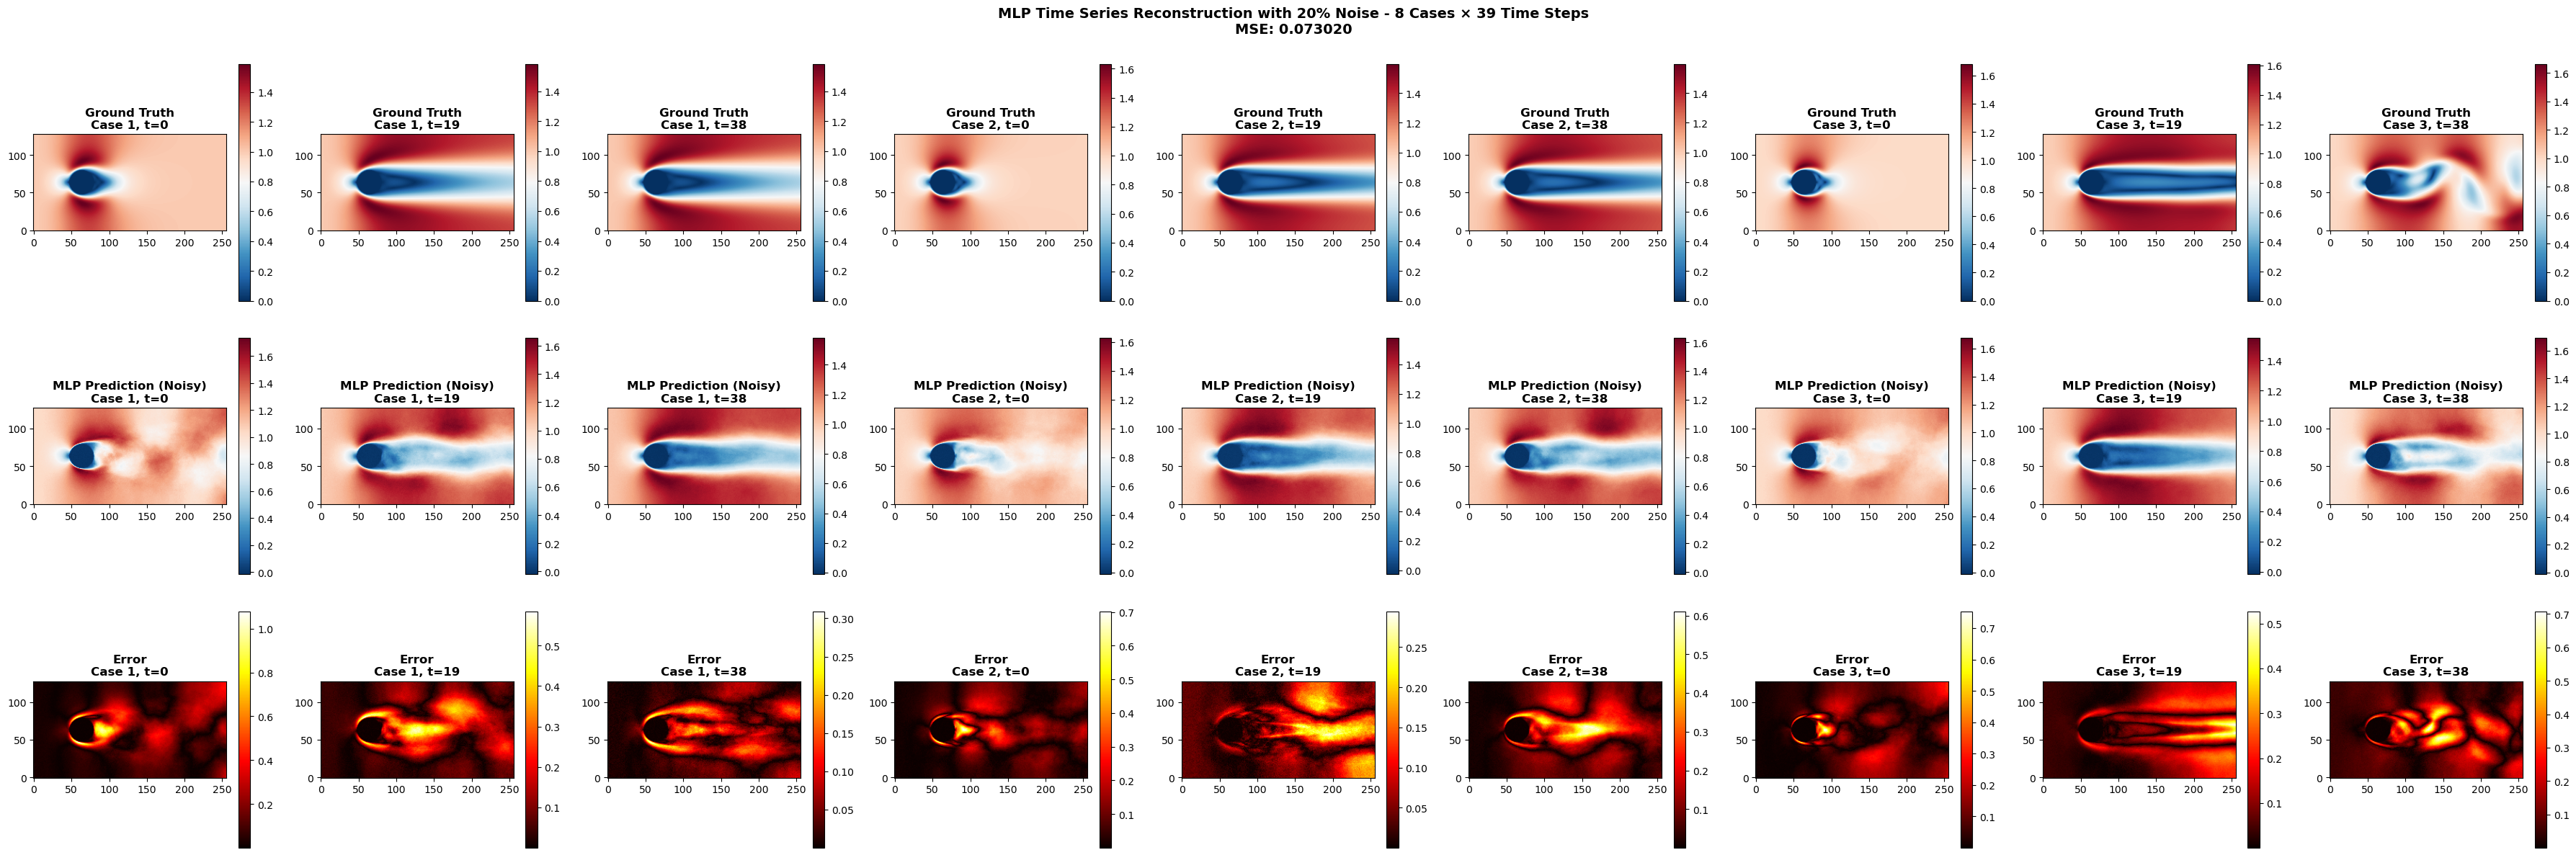


🎉 MLP noisy time series inference completed successfully!
   📊 Final output: (8, 128, 256, 39)
   🔊 Noise: ENABLED
   📈 Noise level: 20% (SNR: 1.93 dB)
   📈 MSE: 0.07301954
   🔗 Correlation: 0.763636
   ⏱️  Total time: 0.94s



In [22]:
# MLP Inference on Test Dataset with Noise Support and Custom Reshaping to (8, 128, 256, 39)
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import time

print("🔮 === MLP TEST DATASET INFERENCE WITH NOISE ===")
print("=" * 60)

# Configuration for inference
save_results = True  # Set to True to save reconstruction results
visualize_samples = True  # Set to True to show visualizations
n_visualization_samples = 6  # Number of samples to visualize
save_format = 'npz'  # Options: 'npz', 'npy', 'both'
results_dir = Path(config['checkpoint_dir']).parent / "inference_results"

# NOISE CONFIGURATION
add_sensor_noise = True  # Set to True to add noise to sensor data
noise_std_percent = 20 # Noise level as percentage of signal range (5% = moderate noise)
noise_seed = 42  # Seed for reproducible noise generation

# Target reshape dimensions - FIXED DIMENSIONS
TARGET_CASES = 8
TARGET_HEIGHT = 128
TARGET_WIDTH = 256
TARGET_TIME = 39

print(f"🎯 Target reshape: ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})")
print(f"🔊 Noise settings: {'Enabled' if add_sensor_noise else 'Disabled'}")
if add_sensor_noise:
    print(f"   Noise level: {noise_std_percent}% of signal range")
    print(f"   Noise seed: {noise_seed}")

def add_gaussian_noise_to_sensors(sensor_data, noise_std_percent=5.0, seed=None):
    """
    Add Gaussian noise to sensor data
    
    Args:
        sensor_data: Input sensor data array
        noise_std_percent: Standard deviation as percentage of signal range
        seed: Random seed for reproducibility
    
    Returns:
        noisy_sensor_data: Sensor data with added noise
        noise_stats: Dictionary with noise statistics
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Calculate signal statistics
    signal_min = np.min(sensor_data)
    signal_max = np.max(sensor_data)
    signal_range = signal_max - signal_min
    signal_std = np.std(sensor_data)
    
    # Calculate noise standard deviation
    noise_std = (noise_std_percent / 100.0) * signal_range
    
    # Generate Gaussian noise
    noise = np.random.normal(0, noise_std, sensor_data.shape)
    
    # Add noise to sensor data
    noisy_sensor_data = sensor_data + noise
    
    # Calculate noise statistics (fix the circular reference)
    noise_actual_std = np.std(noise)
    snr_db = 20 * np.log10(signal_std / noise_actual_std) if noise_actual_std > 0 else float('inf')
    
    noise_stats = {
        'noise_std_percent': noise_std_percent,
        'noise_std_absolute': noise_std,
        'signal_range': signal_range,
        'signal_std': signal_std,
        'signal_min': signal_min,
        'signal_max': signal_max,
        'noise_min': np.min(noise),
        'noise_max': np.max(noise),
        'noise_mean': np.mean(noise),
        'noise_actual_std': noise_actual_std,
        'snr_db': snr_db,
        'seed': seed
    }
    
    print(f"   📊 Noise Statistics:")
    print(f"      Signal range: [{signal_min:.6f}, {signal_max:.6f}]")
    print(f"      Signal std: {signal_std:.6f}")
    print(f"      Noise std (target): {noise_std:.6f}")
    print(f"      Noise std (actual): {noise_actual_std:.6f}")
    print(f"      SNR: {snr_db:.2f} dB")
    
    return noisy_sensor_data, noise_stats

# Create results directory
if save_results:
    results_dir.mkdir(exist_ok=True)
    print(f"📁 Results will be saved to: {results_dir}")

# Check if MLP model is available
if 'mlp_model' not in locals() or mlp_model is None:
    print("❌ MLP model not available!")
    print("   Please load or train the MLP model first")
else:
    print(f"✅ MLP model loaded and ready for inference")
    print(f"   Model type: Direct Sensor-to-Field MLP")
    print(f"   Configuration: {n_sensors_from_dataset} sensors")

    # Load test dataset similar to FLRNet approach
    print(f"\n📂 Loading test dataset...")
    
    # Create test dataset path by adding 'test_' prefix to the filename
    test_dataset_path = str(Path(config['dataset_path']).parent / f"test_{Path(config['dataset_path']).name}")
    print(f"📁 Test dataset path: {test_dataset_path}")

    # Check if test dataset exists
    if not Path(test_dataset_path).exists():
        print(f"❌ Test dataset not found: {test_dataset_path}")
        print("⚠️  Using training data split instead")
        
        # Use existing training datasets
        test_dataset_for_inference = test_dataset
        test_sensor_positions = sensor_positions
        
    else:
        # Load the test dataset directly from the NPZ file
        print(f"📁 Loading test dataset file...")
        test_data = np.load(test_dataset_path)

        # Create test dataset dictionary (only essential keys)
        essential_keys = ['field_data', 'sensor_data', 'sensor_positions']
        test_dataset_dict = {}
        for key in essential_keys:
            if key in test_data:
                test_dataset_dict[key] = test_data[key]
            else:
                print(f"⚠️  Missing key '{key}' in test dataset")

        # Print basic test dataset information
        print(f"📊 Test dataset loaded:")
        for key, value in test_dataset_dict.items():
            if isinstance(value, np.ndarray):
                print(f"   {key}: {value.shape}")

        # Extract test sensor positions
        test_sensor_positions = test_dataset_dict.get('sensor_positions', sensor_positions)

        # Create TensorFlow test datasets
        print(f"📊 Creating TensorFlow test datasets...")
        
        # Limit test dataset size for faster processing
        max_test_samples = min(1000, len(test_dataset_dict['field_data']))
        
        # Create smaller test dataset dictionary
        limited_test_dataset = {}
        for key, value in test_dataset_dict.items():
            if isinstance(value, np.ndarray) and len(value) > max_test_samples:
                limited_test_dataset[key] = value[:max_test_samples]
            else:
                limited_test_dataset[key] = value
        
        print(f"   Limited to {max_test_samples} samples for performance")
        
        # Use smaller batch size for test data
        test_batch_size = min(16, batch_size)
        
        test_train_dataset, test_test_dataset = creator.create_tensorflow_dataset(
            limited_test_dataset,
            batch_size=test_batch_size,
            shuffle=False,  # Don't shuffle test data
            test_split=1.0
        )

        # Add coordinate grids to test datasets
        test_coord_train_dataset = test_train_dataset.map(add_coordinate_grid)
        test_coord_test_dataset = test_test_dataset.map(add_coordinate_grid)

        # Create MLP test dataset
        test_dataset_for_inference = test_coord_test_dataset.map(
            lambda batch: (batch['sensor_data'], batch['field_data'])
        ).prefetch(tf.data.AUTOTUNE)

    # Count total samples
    total_samples = 0
    sample_batch_size = None
    for batch in test_dataset_for_inference.take(1):
        sensor_data, field_data = batch
        sample_batch_size = sensor_data.shape[0]
        break
    
    # Estimate total samples (approximate)
    batches_count = 0
    for _ in test_dataset_for_inference:
        batches_count += 1
    
    estimated_total_samples = batches_count * sample_batch_size
    print(f"   Estimated total samples: {estimated_total_samples}")
    print(f"   Expected for reshape: {TARGET_CASES * TARGET_TIME} = {TARGET_CASES} cases × {TARGET_TIME} time steps")

    # Initialize storage for results
    all_predictions = []
    all_targets = []
    all_sensor_data = []
    all_clean_sensor_data = []  # Store original clean sensor data
    
    # Performance tracking
    inference_times = []
    batch_mses = []
    
    # Global noise statistics
    noise_stats_global = None
    
    print(f"\n🔮 Starting {'noisy' if add_sensor_noise else 'clean'} inference on test dataset...")
    start_time = time.time()
    
    # Process all batches
    for batch_idx, batch in enumerate(test_dataset_for_inference):
        batch_start_time = time.time()
        
        # MLP inference - direct sensor to field prediction
        sensor_data, field_data = batch
        
        # Store clean sensor data
        clean_sensor_data = sensor_data.numpy()
        all_clean_sensor_data.append(clean_sensor_data)
        
        # Add noise to sensor data if enabled
        if add_sensor_noise:
            # Apply noise
            noisy_sensor_data_np, batch_noise_stats = add_gaussian_noise_to_sensors(
                clean_sensor_data, 
                noise_std_percent=noise_std_percent, 
                seed=noise_seed + batch_idx  # Different seed per batch
            )
            
            # Store noise statistics from first batch
            if noise_stats_global is None:
                noise_stats_global = batch_noise_stats
                print(f"   🔊 Global noise statistics captured from first batch")
            
            # Convert back to tensor for MLP inference
            sensor_data_for_inference = tf.constant(noisy_sensor_data_np, dtype=tf.float32)
            
            # Store the noisy sensor data
            all_sensor_data.append(noisy_sensor_data_np)
        else:
            # Use clean sensor data
            sensor_data_for_inference = sensor_data
            all_sensor_data.append(clean_sensor_data)
        
        # MLP prediction
        predictions = mlp_model(sensor_data_for_inference, training=False)
        
        # Store results
        all_predictions.append(predictions.numpy())
        all_targets.append(field_data.numpy())
        
        # Calculate batch metrics
        batch_mse = np.mean((field_data.numpy() - predictions.numpy()) ** 2)
        batch_mses.append(batch_mse)
        
        # Track timing
        batch_time = time.time() - batch_start_time
        inference_times.append(batch_time)
        
        # Progress update
        if (batch_idx + 1) % 5 == 0 or batch_idx == 0:
            avg_time = np.mean(inference_times[-5:])
            noise_label = "NOISY" if add_sensor_noise else "CLEAN"
            print(f"   Batch {batch_idx + 1}/{batches_count} [{noise_label}] - "
                  f"MSE: {batch_mse:.6f}, "
                  f"Time: {batch_time:.3f}s, "
                  f"Avg: {avg_time:.3f}s/batch")
    
    total_time = time.time() - start_time
    
    # Concatenate all results
    print(f"\n📦 Consolidating results...")
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    all_sensor_data = np.concatenate(all_sensor_data, axis=0)  # This is noisy if noise was added
    all_clean_sensor_data = np.concatenate(all_clean_sensor_data, axis=0)  # Always clean
    
    # CUSTOM RESHAPE TO (8, 128, 256, 39) FORMAT
    print(f"\n🔄 Reshaping data to target format ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})...")
    
    # Get original shapes
    original_samples, height, width, n_channels = all_predictions.shape
    print(f"   Original shape: {all_predictions.shape}")
    print(f"   Available samples: {original_samples}")
    print(f"   Required samples: {TARGET_CASES * TARGET_TIME} ({TARGET_CASES} × {TARGET_TIME})")
    
    # Calculate how many samples we need
    required_samples = TARGET_CASES * TARGET_TIME
    
    if original_samples >= required_samples:
        print(f"   ✅ Sufficient samples available")
        
        # Take exactly the number of samples we need
        predictions_subset = all_predictions[:required_samples]
        targets_subset = all_targets[:required_samples]
        sensor_data_subset = all_sensor_data[:required_samples]  # Noisy or clean depending on settings
        clean_sensor_data_subset = all_clean_sensor_data[:required_samples]  # Always clean
        
        # Reshape from (312, 128, 256, 1) to (8, 39, 128, 256, 1)
        predictions_grouped = predictions_subset.reshape(TARGET_CASES, TARGET_TIME, height, width, n_channels)
        targets_grouped = targets_subset.reshape(TARGET_CASES, TARGET_TIME, height, width, n_channels)
        
        # Transpose to (8, 128, 256, 39, 1) then squeeze to (8, 128, 256, 39)
        predictions_reshaped = np.transpose(predictions_grouped, (0, 2, 3, 1, 4)).squeeze(-1)
        targets_reshaped = np.transpose(targets_grouped, (0, 2, 3, 1, 4)).squeeze(-1)
        
        # Reshape sensor data to (8, 39, n_sensors)
        sensor_data_reshaped = sensor_data_subset.reshape(TARGET_CASES, TARGET_TIME, -1)
        clean_sensor_data_reshaped = clean_sensor_data_subset.reshape(TARGET_CASES, TARGET_TIME, -1)
        
        print(f"   ✅ Successfully reshaped to target format:")
        print(f"      - Predictions: {predictions_reshaped.shape} (case, height, width, time)")
        print(f"      - Targets: {targets_reshaped.shape} (case, height, width, time)")
        print(f"      - Sensor data ({'noisy' if add_sensor_noise else 'clean'}): {sensor_data_reshaped.shape} (case, time, sensors)")
        print(f"      - Clean sensor data: {clean_sensor_data_reshaped.shape} (case, time, sensors)")
    
    else:
        print(f"   ⚠️  Insufficient samples: {original_samples} < {required_samples}")
        print(f"   🔄 Padding with zeros to reach target dimensions...")
        
        # Calculate padding needed
        padding_needed = required_samples - original_samples
        
        # Pad predictions and targets
        padding_shape_pred = (padding_needed, height, width, n_channels)
        predictions_padded = np.concatenate([all_predictions, np.zeros(padding_shape_pred)], axis=0)
        targets_padded = np.concatenate([all_targets, np.zeros(padding_shape_pred)], axis=0)
        
        # Pad sensor data
        padding_shape_sensor = (padding_needed, all_sensor_data.shape[1])
        sensor_data_padded = np.concatenate([all_sensor_data, np.zeros(padding_shape_sensor)], axis=0)
        clean_sensor_data_padded = np.concatenate([all_clean_sensor_data, np.zeros(padding_shape_sensor)], axis=0)
        
        # Reshape padded data
        predictions_grouped = predictions_padded.reshape(TARGET_CASES, TARGET_TIME, height, width, n_channels)
        targets_grouped = targets_padded.reshape(TARGET_CASES, TARGET_TIME, height, width, n_channels)
        
        # Transpose to (case, height, width, time)
        predictions_reshaped = np.transpose(predictions_grouped, (0, 2, 3, 1, 4)).squeeze(-1)
        targets_reshaped = np.transpose(targets_grouped, (0, 2, 3, 1, 4)).squeeze(-1)
        
        # Reshape sensor data
        sensor_data_reshaped = sensor_data_padded.reshape(TARGET_CASES, TARGET_TIME, -1)
        clean_sensor_data_reshaped = clean_sensor_data_padded.reshape(TARGET_CASES, TARGET_TIME, -1)
        
        print(f"   ✅ Padded and reshaped to: {predictions_reshaped.shape}")
    
    # Verify final shapes match target exactly
    expected_shape = (TARGET_CASES, TARGET_HEIGHT, TARGET_WIDTH, TARGET_TIME)
    if predictions_reshaped.shape == expected_shape:
        print(f"   🎯 Perfect shape match: {predictions_reshaped.shape}")
    else:
        print(f"   ⚠️  Shape mismatch: got {predictions_reshaped.shape}, expected {expected_shape}")
    
    # Calculate metrics on the reshaped data
    overall_mse = np.mean((targets_reshaped - predictions_reshaped) ** 2)
    overall_mae = np.mean(np.abs(targets_reshaped - predictions_reshaped))
    overall_rmse = np.sqrt(overall_mse)
    max_error = np.max(np.abs(targets_reshaped - predictions_reshaped))
    correlation = np.corrcoef(targets_reshaped.flatten(), predictions_reshaped.flatten())[0, 1]
    
    # Calculate noise impact metrics if noise was added
    if add_sensor_noise:
        # Compare clean vs noisy sensor data
        sensor_noise_mse = np.mean((clean_sensor_data_reshaped - sensor_data_reshaped) ** 2)
        sensor_noise_mae = np.mean(np.abs(clean_sensor_data_reshaped - sensor_data_reshaped))
        
        print(f"\n📊 NOISE IMPACT ANALYSIS:")
        print(f"   Sensor noise MSE: {sensor_noise_mse:.8f}")
        print(f"   Sensor noise MAE: {sensor_noise_mae:.6f}")
        print(f"   SNR: {noise_stats_global['snr_db']:.2f} dB")
        print(f"   Noise level: {noise_std_percent}% of signal range")
    
    print(f"\n📊 MLP INFERENCE RESULTS SUMMARY:")
    print(f"   Output format: (case, height, width, time) = ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})")
    print(f"   Noise status: {'ENABLED' if add_sensor_noise else 'DISABLED'}")
    if add_sensor_noise:
        print(f"   Noise level: {noise_std_percent}% (SNR: {noise_stats_global['snr_db']:.2f} dB)")
    print(f"   Total inference time: {total_time:.2f}s")
    print(f"\n📈 RECONSTRUCTION METRICS:")
    print(f"   MSE: {overall_mse:.8f}")
    print(f"   RMSE: {overall_rmse:.6f}")
    print(f"   MAE: {overall_mae:.6f}")
    print(f"   Max Error: {max_error:.6f}")
    print(f"   Correlation: {correlation:.6f}")
    
    # Save results if requested
    if save_results:
        print(f"\n💾 Saving {'noisy' if add_sensor_noise else 'clean'} time series results in format ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})...")
        
        # Create comprehensive results dictionary
        results_dict = {
            # Main results in target format
            'predictions': predictions_reshaped,  # Shape: (8, 128, 256, 39)
            'targets': targets_reshaped,          # Shape: (8, 128, 256, 39)
            'sensor_data': sensor_data_reshaped,  # Shape: (8, 39, n_sensors) - noisy if noise enabled
            'clean_sensor_data': clean_sensor_data_reshaped,  # Shape: (8, 39, n_sensors) - always clean
            'sensor_positions': test_sensor_positions, # Shape: (n_sensors, 2)
            
            # Shape information
            'shape_info': {
                'n_cases': TARGET_CASES,
                'height': TARGET_HEIGHT,
                'width': TARGET_WIDTH,
                'time_steps': TARGET_TIME,
                'n_sensors': n_sensors_from_dataset,
                'format': f'({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})',
                'description': f'{TARGET_CASES} cases with {TARGET_TIME} time steps each'
            },
            
            # Metrics and configuration
            'metrics': {
                'mse': overall_mse,
                'rmse': overall_rmse,
                'mae': overall_mae,
                'max_error': max_error,
                'correlation': correlation
            },
            
            'config': {
                'model_name': model_name,
                'n_sensors': n_sensors_from_dataset,
                'model_type': 'MLP',
                'input_shape': tuple(config['model']['input_shape']),
                'hidden_layers': mlp_config['hidden_layers'],
                'activation': mlp_config['activation'],
                'dropout_rate': mlp_config['dropout_rate'],
                'use_batch_norm': mlp_config['use_batch_norm']
            },
            
            'inference_info': {
                'total_cases': TARGET_CASES,
                'time_steps': TARGET_TIME,
                'total_time': total_time,
                'noise_enabled': add_sensor_noise,
                'timestamp': time.strftime('%Y%m%d_%H%M%S')
            }
        }
        
        # Add noise information if noise was applied
        if add_sensor_noise and noise_stats_global is not None:
            results_dict['noise_info'] = noise_stats_global
            results_dict['metrics']['sensor_noise_mse'] = sensor_noise_mse
            results_dict['metrics']['sensor_noise_mae'] = sensor_noise_mae
        
        # Generate filename - include noise info in name
        noise_suffix = f"_noise{noise_std_percent:.0f}p" if add_sensor_noise else "_clean"
        filename_base = f"mlp_{config_name}{noise_suffix}"

        # Save as NPZ
        npz_path = results_dir / f"{filename_base}.npz"
        np.savez_compressed(npz_path, **results_dict)
        print(f"   ✅ Results saved: {npz_path}")
        print(f"      - Predictions: {predictions_reshaped.shape}")
        print(f"      - Targets: {targets_reshaped.shape}")
        print(f"      - Sensor data ({'noisy' if add_sensor_noise else 'clean'}): {sensor_data_reshaped.shape}")
        print(f"      - Clean sensor data: {clean_sensor_data_reshaped.shape}")
        print(f"      - Format: ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})")
    
    # Visualization for time series data
    if visualize_samples:
        print(f"\n🎨 Creating {'noisy' if add_sensor_noise else 'clean'} time series visualization...")
        
        # Visualize first few cases and time steps
        n_cases_to_show = min(3, TARGET_CASES)
        n_times_to_show = min(3, TARGET_TIME)
        
        fig, axes = plt.subplots(3, n_cases_to_show * n_times_to_show, 
                                figsize=(4 * n_cases_to_show * n_times_to_show, 12))
        
        if axes.ndim == 1:
            axes = axes.reshape(3, -1)
        
        plot_idx = 0
        for case_idx in range(n_cases_to_show):
            # Show evenly spaced time steps
            time_indices = np.linspace(0, TARGET_TIME-1, n_times_to_show, dtype=int)
            
            for t_idx in time_indices:
                if plot_idx < axes.shape[1]:
                    # Ground truth
                    im1 = axes[0, plot_idx].imshow(targets_reshaped[case_idx, :, :, t_idx], 
                                                  cmap='RdBu_r', origin='lower')
                    axes[0, plot_idx].set_title(f'Ground Truth\nCase {case_idx+1}, t={t_idx}', fontweight='bold')
                    plt.colorbar(im1, ax=axes[0, plot_idx], shrink=0.8)
                    
                    # Prediction
                    im2 = axes[1, plot_idx].imshow(predictions_reshaped[case_idx, :, :, t_idx], 
                                                  cmap='RdBu_r', origin='lower')
                    noise_label = f" ({'Noisy' if add_sensor_noise else 'Clean'})"
                    axes[1, plot_idx].set_title(f'MLP Prediction{noise_label}\nCase {case_idx+1}, t={t_idx}', fontweight='bold')
                    plt.colorbar(im2, ax=axes[1, plot_idx], shrink=0.8)
                    
                    # Error
                    error = np.abs(targets_reshaped[case_idx, :, :, t_idx] - 
                                  predictions_reshaped[case_idx, :, :, t_idx])
                    im3 = axes[2, plot_idx].imshow(error, cmap='hot', origin='lower')
                    axes[2, plot_idx].set_title(f'Error\nCase {case_idx+1}, t={t_idx}', fontweight='bold')
                    plt.colorbar(im3, ax=axes[2, plot_idx], shrink=0.8)
                    
                    plot_idx += 1
        
        plt.tight_layout()
        noise_title = f" with {noise_std_percent}% Noise" if add_sensor_noise else " (Clean)"
        plt.suptitle(f'MLP Time Series Reconstruction{noise_title} - {TARGET_CASES} Cases × {TARGET_TIME} Time Steps\nMSE: {overall_mse:.6f}', 
                    y=1.02, fontsize=14, fontweight='bold')
        plt.show()
    
    print(f"\n🎉 MLP {'noisy' if add_sensor_noise else 'clean'} time series inference completed successfully!")
    print(f"   📊 Final output: ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})")
    print(f"   🔊 Noise: {'ENABLED' if add_sensor_noise else 'DISABLED'}")
    if add_sensor_noise:
        print(f"   📈 Noise level: {noise_std_percent}% (SNR: {noise_stats_global['snr_db']:.2f} dB)")
    print(f"   📈 MSE: {overall_mse:.8f}")
    print(f"   🔗 Correlation: {correlation:.6f}")
    print(f"   ⏱️  Total time: {total_time:.2f}s")

print(f"\n" + "=" * 60)